In [1]:
#imports
import spatialdata
import dask_image.imread
import dask.array as da
import napari_spatialdata

import sys, os
sys.path.append(os.path.abspath("../src/opendvp"))
import anndata_utils

for package in [spatialdata, napari_spatialdata]:
    print(f"{package.__name__}: {package.__version__}")

import anndata as ad

/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


spatialdata: 0.2.3
napari_spatialdata: 0.5.3


In [5]:
#paths
path_to_image = "../data/TNBC_subset/image/TD_15_TNBC_subset.ome.tif"
path_to_mask = "../data/TNBC_subset/mask/TD_15_TNBC_subset.tif"
path_to_quant = "../data/TNBC_subset/quant/TD_15_TNBC_subset.csv" 

In [6]:
#create sdata
sdata = spatialdata.SpatialData()

In [7]:
#parse mIF image
image = dask_image.imread.imread(path_to_image)
sdata['image'] = spatialdata.models.Image2DModel.parse(image)

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


In [8]:
#parse mask
mask = dask_image.imread.imread(path_to_mask)
mask = da.squeeze(mask) #remove singleton dimension
sdata['mask'] = spatialdata.models.Labels2DModel.parse(mask)

INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


In [9]:
#parse quantification table
adata = anndata_utils.read_quant(path_to_quant) #create adata from csv
sdata["imaging"] = spatialdata.models.TableModel.parse(adata)

2025-04-15 15:54:03.494 | INFO     | anndata_utils:read_quant:26 -  ---- read_quant : version number 1.1.0 ----
2025-04-15 15:54:03.579 | INFO     | anndata_utils:read_quant:46 -  16808 cells and 15 variables
2025-04-15 15:54:03.580 | INFO     | anndata_utils:read_quant:47 -  ---- read_quant is done, took 0s  ----


In [10]:
sdata['imaging'].write_h5ad("../data/TNBC_subset/adata/20250415_adata.h5ad")

In [11]:
sdata

SpatialData object
├── Images
│     └── 'image': DataArray[cyx] (15, 5000, 5000)
├── Labels
│     └── 'mask': DataArray[yx] (5000, 5000)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels)

In [13]:
#write as zarr object
sdata.write("../data/TNBC_subset/sdata.zarr")

INFO     The Zarr backing store has been changed from None the new file path: ../data/TNBC_subset/sdata.zarr       


### filter by initial dapi signal

In [ ]:
feature_to_filter = "mean_DAPI_bg"

In [ ]:
import filtering
import pandas as pd

In [17]:
df = pd.DataFrame(data=sdata['imaging'].X, columns=sdata['imaging'].var_names)
filtering.plot_dynamic_histogram(df, feature_to_filter, bins=300)

In [19]:
# now visualize in sdata
sdata['imaging'] = filtering.filter_by_abs_value(
    adata=sdata['imaging'], 
    marker=feature_to_filter,
    value=6,
    keep='above',
    plot=False)

2025-04-15 16:08:00.970 | INFO     | filtering:filter_by_abs_value:126 -  ---- filter_by_abs_value : version number 1.1.0 ----
2025-04-15 16:08:00.991 | INFO     | filtering:filter_by_abs_value:160 - Number of cells with mean_DAPI_bg above 6: 16794
2025-04-15 16:08:00.993 | INFO     | filtering:filter_by_abs_value:175 -  ---- filter_by_abs_value is done, took 0s  ----
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning:

Key `imaging` already exists. Overwriting it in-memory.



In [20]:
sdata['imaging'] = filtering.filter_by_abs_value(
    adata=sdata['imaging'], 
    marker=feature_to_filter,
    value=50,
    keep='below',
    plot=False)

2025-04-15 16:09:14.852 | INFO     | filtering:filter_by_abs_value:126 -  ---- filter_by_abs_value : version number 1.1.0 ----
2025-04-15 16:09:14.865 | INFO     | filtering:filter_by_abs_value:160 - Number of cells with mean_DAPI_bg below 50: 16692
2025-04-15 16:09:14.866 | INFO     | filtering:filter_by_abs_value:175 -  ---- filter_by_abs_value is done, took 0s  ----
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning:

Key `imaging` already exists. Overwriting it in-memory.



In [21]:
# since two filters were applied, let's merge them
sdata['imaging'].obs['DNA_filter'] = sdata['imaging'].obs[f'mean_DAPI_bg_above_6'] & sdata['imaging'].obs['mean_DAPI_bg_below_50']

In [22]:
sdata['imaging'].obs.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,mean_DAPI_bg_above_6,mean_DAPI_bg_below_50,DNA_filter
0,0,17.612598,53.337008,1270.0,48.198269,36.841132,0.644782,0.359469,146.669048,0.949178,True,True,True
1,1,6.598958,126.006944,576.0,45.835698,18.372329,0.916152,1.513685,113.112698,0.886154,True,True,True
2,2,17.416667,156.656504,984.0,40.751104,31.700565,0.628380,-1.528462,121.396970,0.955340,True,True,True
3,3,4.982558,179.337209,344.0,34.620290,13.577757,0.919884,1.474818,82.627417,0.971751,True,True,True
4,4,19.159558,228.598210,1899.0,54.446578,49.053930,0.433912,1.287374,196.610173,0.896601,True,True,True


### Filter by ratio between first and last dapi signal

In [23]:
# explore the data
df = pd.DataFrame(data=sdata['imaging'].X, columns=sdata['imaging'].var_names)
df['DNA_ratio'] = df['mean_DAPI_2'] / df['mean_DAPI_bg']
filtering.plot_dynamic_histogram(df, "DNA_ratio", bins=300)

2025-04-15 16:11:56.086 | INFO     | filtering:filter_by_ratio:181 -  ---- filter_by_ratio : version number 1.1.0 ----
2025-04-15 16:11:56.093 | INFO     | filtering:filter_by_ratio:199 - Number of cells with DAPI ratio < 0.3: 1113
2025-04-15 16:11:56.095 | INFO     | filtering:filter_by_ratio:200 - Number of cells with DAPI ratio > 0.8: 171
2025-04-15 16:11:56.097 | INFO     | filtering:filter_by_ratio:201 - Number of cells with DAPI ratio between 0.3 and 0.8: 15524
2025-04-15 16:11:56.099 | INFO     | filtering:filter_by_ratio:202 - Percentage of cells filtered out: 7.64%


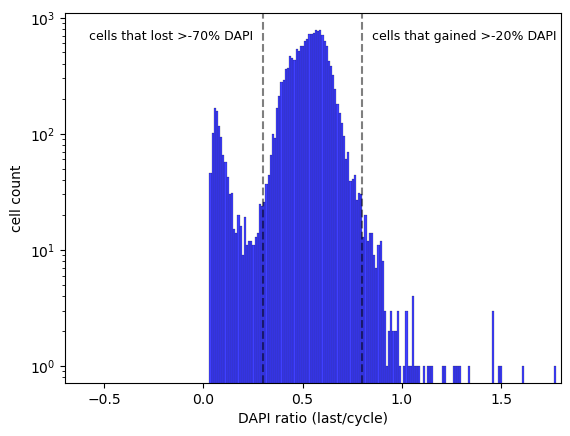

2025-04-15 16:11:56.425 | INFO     | filtering:filter_by_ratio:222 -  ---- filter_by_ratio is done, took 0s  ----
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning:

Key `imaging` already exists. Overwriting it in-memory.



In [24]:
sdata['imaging'] = filtering.filter_by_ratio(
                    sdata['imaging'],
                    end_cycle='mean_DAPI_2', 
                    start_cycle="mean_DAPI_bg", 
                    label="DAPI", 
                    min_ratio=0.3, max_ratio=0.8
                    )

In [26]:
sdata['imaging'].obs.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,mean_DAPI_bg_above_6,mean_DAPI_bg_below_50,DNA_filter,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass
0,0,17.612598,53.337008,1270.0,48.198269,36.841132,0.644782,0.359469,146.669048,0.949178,True,True,True,0.065991,False,True,False
1,1,6.598958,126.006944,576.0,45.835698,18.372329,0.916152,1.513685,113.112698,0.886154,True,True,True,0.107462,False,True,False
2,2,17.416667,156.656504,984.0,40.751104,31.700565,0.628380,-1.528462,121.396970,0.955340,True,True,True,0.098039,False,True,False
3,3,4.982558,179.337209,344.0,34.620290,13.577757,0.919884,1.474818,82.627417,0.971751,True,True,True,0.136228,False,True,False
4,4,19.159558,228.598210,1899.0,54.446578,49.053930,0.433912,1.287374,196.610173,0.896601,True,True,True,0.104794,False,True,False


### Filter by manual annotations

2025-04-15 16:13:28.593 | INFO     | filtering:filter_by_annotation:231 -  ---- filter_by_annotation : version number 2.0.1 ----
2025-04-15 16:13:28.594 | INFO     | filtering:filter_by_annotation:232 -  Each class of annotation will be a different column in adata.obs
2025-04-15 16:13:28.594 | INFO     | filtering:filter_by_annotation:233 -  TRUE means cell was inside annotation, FALSE means cell not in annotation
2025-04-15 16:13:28.759 | INFO     | filtering:filter_by_annotation:240 - GeoJson loaded, detected: 10 annotations


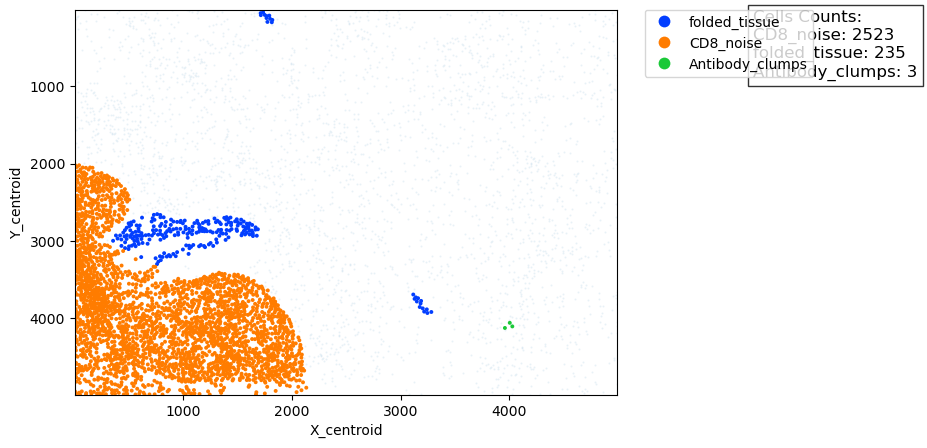

/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning:

Key `imaging` already exists. Overwriting it in-memory.



In [27]:
#needs geojson file, with some classifications
sdata['imaging'] = filtering.filter_by_annotation(
                        adata=sdata['imaging'],
                        path_to_geojson="../data/TNBC_subset/geojsons/TNBC_subset_annotations.geojson"
                        )

In [28]:
sdata['imaging'].obs.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,...,mean_DAPI_bg_below_50,DNA_filter,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,CD8_noise,Antibody_clumps,folded_tissue,artefact
0,0,17.612598,53.337008,1270.0,48.198269,36.841132,0.644782,0.359469,146.669048,0.949178,...,True,True,0.065991,False,True,False,False,False,False,False
1,1,6.598958,126.006944,576.0,45.835698,18.372329,0.916152,1.513685,113.112698,0.886154,...,True,True,0.107462,False,True,False,False,False,False,False
2,2,17.416667,156.656504,984.0,40.751104,31.700565,0.628380,-1.528462,121.396970,0.955340,...,True,True,0.098039,False,True,False,False,False,False,False
3,3,4.982558,179.337209,344.0,34.620290,13.577757,0.919884,1.474818,82.627417,0.971751,...,True,True,0.136228,False,True,False,False,False,False,False
4,4,19.159558,228.598210,1899.0,54.446578,49.053930,0.433912,1.287374,196.610173,0.896601,...,True,True,0.104794,False,True,False,False,False,False,False


In [31]:
sdata['imaging'].obs.artefact.value_counts()

artefact
False    14047
True      2761
Name: count, dtype: int64

### Visualize filtered cells

In [32]:
# create shapes from mask
sdata['mask_polygons'] = spatialdata.to_polygons(sdata['mask'])

In [34]:
assert sdata['imaging'].shape[0] == sdata['mask_polygons'].shape[0]
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/TNBC_subset/sdata.zarr
├── Images
│     └── 'image': DataArray[cyx] (15, 5000, 5000)
├── Labels
│     └── 'mask': DataArray[yx] (5000, 5000)
├── Shapes
│     └── 'mask_polygons': GeoDataFrame shape: (16808, 2) (2D shapes)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels), mask_polygons (Shapes)
with the following elements not in the Zarr store:
    ▸ mask_polygons (Shapes)

### Link table with polygons for visualizing any adata.obs column

In [36]:
sdata['imaging'].obs.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,...,mean_DAPI_bg_below_50,DNA_filter,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,CD8_noise,Antibody_clumps,folded_tissue,artefact
0,0,17.612598,53.337008,1270.0,48.198269,36.841132,0.644782,0.359469,146.669048,0.949178,...,True,True,0.065991,False,True,False,False,False,False,False
1,1,6.598958,126.006944,576.0,45.835698,18.372329,0.916152,1.513685,113.112698,0.886154,...,True,True,0.107462,False,True,False,False,False,False,False
2,2,17.416667,156.656504,984.0,40.751104,31.700565,0.628380,-1.528462,121.396970,0.955340,...,True,True,0.098039,False,True,False,False,False,False,False
3,3,4.982558,179.337209,344.0,34.620290,13.577757,0.919884,1.474818,82.627417,0.971751,...,True,True,0.136228,False,True,False,False,False,False,False
4,4,19.159558,228.598210,1899.0,54.446578,49.053930,0.433912,1.287374,196.610173,0.896601,...,True,True,0.104794,False,True,False,False,False,False,False


In [39]:
sdata['mask_polygons'].head()

,label,geometry
label,,
1,1,"POLYGON ((60 43.5, 59 43.5, 58 43.5, 57 43.5, ..."
2,2,"POLYGON ((134 19.5, 133 19.5, 132 19.5, 131 19..."
3,3,"POLYGON ((156 33.5, 155 33.5, 154 33.5, 153 33..."
4,4,"POLYGON ((188 13.5, 187 13.5, 186 13.5, 185 13..."
5,5,"POLYGON ((235 48.5, 234 48.5, 233 48.5, 232.5 ..."


In [40]:
# since not compatible we will add 1 to all CellID values in table
sdata['imaging'].obs['CellID'] = sdata['imaging'].obs['CellID'] + 1

In [41]:
sdata['imaging'].obs.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,...,mean_DAPI_bg_below_50,DNA_filter,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,CD8_noise,Antibody_clumps,folded_tissue,artefact
0,1,17.612598,53.337008,1270.0,48.198269,36.841132,0.644782,0.359469,146.669048,0.949178,...,True,True,0.065991,False,True,False,False,False,False,False
1,2,6.598958,126.006944,576.0,45.835698,18.372329,0.916152,1.513685,113.112698,0.886154,...,True,True,0.107462,False,True,False,False,False,False,False
2,3,17.416667,156.656504,984.0,40.751104,31.700565,0.628380,-1.528462,121.396970,0.955340,...,True,True,0.098039,False,True,False,False,False,False,False
3,4,4.982558,179.337209,344.0,34.620290,13.577757,0.919884,1.474818,82.627417,0.971751,...,True,True,0.136228,False,True,False,False,False,False,False
4,5,19.159558,228.598210,1899.0,54.446578,49.053930,0.433912,1.287374,196.610173,0.896601,...,True,True,0.104794,False,True,False,False,False,False,False


In [43]:
# check datatypes
print(sdata['mask_polygons'].label.dtype)
print(sdata['imaging'].obs.CellID.dtype)

int64
int64


In [44]:
sdata['imaging'].obs["shapes"] = "mask_polygons"
sdata['imaging'].obs["shapes"] = sdata['imaging'].obs["shapes"].astype("category")

sdata['imaging'] = spatialdata.models.TableModel.parse(
    sdata['imaging'], 
    region = "mask_polygons", 
    region_key = "shapes", 
    instance_key = "CellID")


/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning:

Key `imaging` already exists. Overwriting it in-memory.



In [47]:
#write new elements
sdata.write("../data/TNBC_subset/sdata/20250415_sdata.zarr")

INFO     The Zarr backing store has been changed from ../data/TNBC_subset/sdata.zarr the new file path:            
         ../data/TNBC_subset/sdata/20250415_sdata.zarr                                                             


### phenotyping

Lets reduce the CD8 value for cells labelled with CD8_noise

In [49]:
from opendvp import phenotyping

In [50]:
sdata['imaging'] = phenotyping.negate_var_by_ann(
    adata=sdata['imaging'],
    target_variable = "mean_CD8",
    target_annotation_column="CD8_noise",
    quantile_for_imputation=0.05
    )

/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

2025-04-15 16:26:08.831 | INFO     | opendvp.phenotyping:negate_var_by_ann:58 - Imputing with 0.05% percentile value = 6.356338284753363
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning:

Key `imaging` already exists. Overwriting it in-memory.



In [51]:
#store gates in the varm of sdata['imaging']
gates = pd.read_csv("../data/TNBC_subset/gating_folder/gates.csv")
gates.index = gates['marker_id'].values
sdata['imaging'].varm['gates'] = gates
sdata['imaging']

AnnData object with n_obs × n_vars = 16808 × 15
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'mean_DAPI_bg_above_6', 'mean_DAPI_bg_below_50', 'DNA_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'CD8_noise', 'Antibody_clumps', 'folded_tissue', 'artefact', 'shapes'
    var: 'math', 'marker'
    uns: 'spatialdata_attrs'
    varm: 'gates'

In [52]:
sdata['imaging'].varm['gates'].iloc[5:10,:]

,sample_id,marker_id,gate_value
mean_Vimentin,TD_15_TNBC_subset,mean_Vimentin,5.792953
mean_CD3e,TD_15_TNBC_subset,mean_CD3e,7.489209
mean_panCK,TD_15_TNBC_subset,mean_panCK,2.625427
mean_CD8,TD_15_TNBC_subset,mean_CD8,17.000000
mean_DAPI_1,TD_15_TNBC_subset,mean_DAPI_1,0.000000


In [53]:
gates = phenotyping.read_gates("../data/TNBC_subset/gating_folder/gates.csv", sample_id="TD_15_TNBC_subset")

2025-04-15 16:26:49.068 | INFO     | opendvp.phenotyping:read_gates:12 -  ---- read_gates : version number 1.1.0 ----
2025-04-15 16:26:49.071 | INFO     | opendvp.phenotyping:read_gates:18 -    Filtering out all rows with value 0.0 (assuming not gated)
2025-04-15 16:26:49.072 | INFO     | opendvp.phenotyping:read_gates:21 -   Found 8 valid gates
2025-04-15 16:26:49.073 | INFO     | opendvp.phenotyping:read_gates:22 -   Markers found: ['mean_Vimentin' 'mean_CD3e' 'mean_panCK' 'mean_CD8' 'mean_COL1A1'
 'mean_CD20' 'mean_CD68' 'mean_Ki67']
2025-04-15 16:26:49.073 | INFO     | opendvp.phenotyping:read_gates:23 -   Samples found: ['TD_15_TNBC_subset']
2025-04-15 16:26:49.074 | INFO     | opendvp.phenotyping:read_gates:28 -   Found 8 valid gates for sample TD_15_TNBC_subset
2025-04-15 16:26:49.074 | INFO     | opendvp.phenotyping:read_gates:30 -  ---- read_gates is done, took 0s  ----


In [54]:
gates_for_scimap = phenotyping.process_gates_for_sm(gates, sample_id="TD_15_TNBC_subset")
gates_for_scimap

2025-04-15 16:26:57.541 | INFO     | opendvp.phenotyping:process_gates_for_sm:35 -  ---- process_gates_for_sm : version number 1.2.0 ----
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/opendvp/phenotyping.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-04-15 16:26:57.545 | INFO     | opendvp.phenotyping:process_gates_for_sm:44 -  ---- process_gates_for_sm is done, took 0s  ----


,markers,TD_15_TNBC_subset
5,mean_Vimentin,1.915886
6,mean_CD3e,2.138796
7,mean_panCK,1.287972
8,mean_CD8,2.890372
10,mean_COL1A1,3.169333
11,mean_CD20,3.205329
12,mean_CD68,1.436576
13,mean_Ki67,1.093354


In [55]:
# we have to add sample id to adata obs
sdata['imaging'].obs['imageid'] = "TD_15_TNBC_subset"

In [56]:
#create filtered adata
adata_for_gating = sdata['imaging'][:, sdata['imaging'].var_names.isin(gates_for_scimap['markers'])].copy()
adata_for_gating

AnnData object with n_obs × n_vars = 16808 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'mean_DAPI_bg_above_6', 'mean_DAPI_bg_below_50', 'DNA_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'CD8_noise', 'Antibody_clumps', 'folded_tissue', 'artefact', 'shapes', 'imageid'
    var: 'math', 'marker'
    uns: 'spatialdata_attrs'
    varm: 'gates'

In [61]:
import importlib
importlib.reload(phenotyping)

<module 'opendvp.phenotyping' from '/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/opendvp/phenotyping.py'>

In [58]:
rescaled_adata_for_gating = phenotyping.rescale(
                                adata_for_gating, 
                                gate=gates_for_scimap, 
                                method='all'
                                )


Scaling Image: TD_15_TNBC_subset
Scaling mean_Vimentin (gate: 1.916)
Scaling mean_CD3e (gate: 2.139)
Scaling mean_panCK (gate: 1.288)
Scaling mean_CD8 (gate: 2.890)
Scaling mean_COL1A1 (gate: 3.169)
Scaling mean_CD20 (gate: 3.205)
Scaling mean_CD68 (gate: 1.437)
Scaling mean_Ki67 (gate: 1.093)


/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/opendvp/phenotyping.py:188: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [60]:
# load the phenotyping workflow
phenotype = pd.read_csv('../data/TNBC_subset/phenotyping/Phenotype_Matrix_TNBC.csv')
phenotype.style.format(na_rep='')

,Unnamed: 0,Unnamed: 1,Vimentin,CD3e,panCK,CD8,COL1A1,CD20,CD68,Ki67
0,all,Epithelial,,,pos,,,,,
1,all,Mesenchymal,pos,,,,,,,
2,all,Immune,,anypos,,anypos,,anypos,anypos,
3,all,Fibroblasts,,,,,pos,,,
4,Immune,CD4_T_cell,,pos,,neg,,,,
5,Immune,CD8_T_cell,,,,pos,,,,
6,Immune,B_cell,,,,,,pos,,
7,Immune,Macrophage,,,,,,,pos,


In [62]:
rescaled_adata_for_gating.var['feature_name']  = rescaled_adata_for_gating.var.index
rescaled_adata_for_gating.var.index = rescaled_adata_for_gating.var['marker']

In [63]:
adata_phenotyped = phenotyping.phenotype_cells(
    rescaled_adata_for_gating, 
    phenotype=phenotype, 
    label="phenotype",
    verbose=True) 

Phenotyping Epithelial
Phenotyping Mesenchymal
Phenotyping Immune
Phenotyping Fibroblasts
-- Subsetting Immune
Phenotyping CD4_T_cell
Phenotyping CD8_T_cell
Phenotyping B_cell
Phenotyping Macrophage
Consolidating the phenotypes across all groups


/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/opendvp/phenotyping.py:721: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/opendvp/phenotyping.py:721: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [64]:
adata_phenotyped.obs['phenotype'].value_counts()

phenotype
Epithelial     7766
Unknown        4070
CD4_T_cell     3159
Fibroblasts     830
Mesenchymal     655
CD8_T_cell      200
B_cell          112
Macrophage       16
Name: count, dtype: int64

In [65]:
sdata['imaging'].obs['phenotype'] = adata_phenotyped.obs['phenotype'].values

In [67]:
sdata.write("../data/TNBC_subset/sdata/20250415_sdata_phenotyped.zarr")

INFO     The Zarr backing store has been changed from ../data/TNBC_subset/sdata/20250415_sdata.zarr the new file   
         path: ../data/TNBC_subset/sdata/20250415_sdata_phenotyped.zarr                                            


In [69]:
sdata['imaging'].write_h5ad("../data/TNBC_subset/adata/20250415_adata_phenotyped.h5ad")

### export segmentation mask with phenotype colors

In [70]:
sdata['mask_polygons']

,label,geometry
label,,
1,1,"POLYGON ((60 43.5, 59 43.5, 58 43.5, 57 43.5, ..."
2,2,"POLYGON ((134 19.5, 133 19.5, 132 19.5, 131 19..."
3,3,"POLYGON ((156 33.5, 155 33.5, 154 33.5, 153 33..."
4,4,"POLYGON ((188 13.5, 187 13.5, 186 13.5, 185 13..."
5,5,"POLYGON ((235 48.5, 234 48.5, 233 48.5, 232.5 ..."
...,...,...
16804,16804,"POLYGON ((133 5000.5, 132 5000.5, 131 5000.5, ..."
16805,16805,"POLYGON ((830 5000.5, 829 5000.5, 828 5000.5, ..."
16806,16806,"POLYGON ((671 5000.5, 670 5000.5, 669 5000.5, ..."


In [73]:
import json
with open("/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/assets/pheno_colors.json", "r") as f:
    loaded_dict = json.load(f)

In [75]:
sdata['imaging'].obs.phenotype.unique()

['Epithelial', 'Unknown', 'CD4_T_cell', 'Mesenchymal', 'Fibroblasts', 'CD8_T_cell', 'Macrophage', 'B_cell']
Categories (8, object): ['B_cell', 'CD4_T_cell', 'CD8_T_cell', 'Epithelial', 'Fibroblasts', 'Macrophage', 'Mesenchymal', 'Unknown']

In [77]:
loaded_dict = {'B_cell': '#ff7df3',
                'CD4_T_cell': '#6efa6e',
                'CD8_T_cell': '#2020d8',
                'Epithelial': '#f55148',
                'Mesenchymal': '#866a21',
                'Macrophage': '#ffff00',
                'Fibroblasts': '#ff7f0e',
                'Unknown': '#7f7f7f'}

In [76]:
loaded_dict

{'B_cells': '#ff7df3',
 'CD4_Tcells': '#6efa6e',
 'CD8_Tcells': '#2020d8',
 'Cancer_cells': '#f55148',
 'Vimentin_cells': '#866a21',
 'Macrophages': '#ffff00',
 'COL1A1_cells': '#ff7f0e',
 'Unknown': '#7f7f7f'}

In [ ]:
anndata_utils.color_geojson_w_adata(
    geodataframe = sdata['mask_polygons'],
    geodataframe_index_key = "label",
    adata = sdata['imaging'],
    adata_obs_index_key = 'CellID',
    adata_obs_category_key =  "phenotype",
    color_dict = loaded_dict,
    export_path = "../data/TNBC_subset/qc/20250415_mask_pheno.geojson",
    simplify_value=1,
    )

2025-04-15 17:03:46.551 | INFO     | anndata_utils:color_geojson_w_adata:152 -  -- Adding color to polygons for QuPath visualization -- 
2025-04-15 17:03:46.556 | INFO     | anndata_utils:color_geojson_w_adata:165 - Matching gdf[label] to adata.obs[CellID]
2025-04-15 17:03:46.559 | INFO     | opendvp.utils:parse_color_for_qupath:121 - Parsing colors compatible with QuPath
2025-04-15 17:03:46.559 | INFO     | opendvp.utils:parse_color_for_qupath:130 - Custom color dictionary passed, adapting to QuPath color format
2025-04-15 17:03:46.653 | INFO     | anndata_utils:color_geojson_w_adata:188 - Simplifying the geometry with tolerance 1
2025-04-15 17:03:48.921 | INFO     | anndata_utils:color_geojson_w_adata:191 - Simplified all polygons in 2.3 seconds
2025-04-15 17:03:48.921 | INFO     | anndata_utils:color_geojson_w_adata:195 - Writing polygons as geojson file
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning:


In [106]:
importlib.reload(anndata_utils)

anndata_utils.adataobs_to_voronoi_geojson(
                adata = sdata['imaging'],
                subset_adata_key = None, 
                subset_adata_value = None,
                color_by_adata_key = "phenotype",
                color_dict = loaded_dict ,
                threshold_quantile = 0.995,
                merge_adjacent_shapes = True,
                save_as_detection = True,  
                output_filepath = "../data/TNBC_subset/qc/20250415_voronoi_pheno.geojson",
                )

2025-04-15 17:13:07.345 | INFO     | anndata_utils:adataobs_to_voronoi_geojson:283 - Running Voronoi
2025-04-15 17:13:07.848 | INFO     | anndata_utils:adataobs_to_voronoi_geojson:293 - Voronoi done
2025-04-15 17:13:07.850 | INFO     | anndata_utils:adataobs_to_voronoi_geojson:297 - Transformed to geodataframe
2025-04-15 17:13:07.852 | INFO     | anndata_utils:adataobs_to_voronoi_geojson:302 - Bounding box: x_min: 4.4, x_max: 4994.9, y_min: 4.3, y_max 4994.3
2025-04-15 17:13:07.888 | INFO     | anndata_utils:adataobs_to_voronoi_geojson:307 - Retaining 16366 valid polygons after filtering large and infinite ones.
2025-04-15 17:13:07.892 | INFO     | anndata_utils:adataobs_to_voronoi_geojson:312 - Filtered out large polygons based on the 0.995 quantile
2025-04-15 17:13:07.893 | INFO     | anndata_utils:adataobs_to_voronoi_geojson:320 - Merging polygons adjacent and of same category
2025-04-15 17:13:08.461 | INFO     | opendvp.utils:parse_color_for_qupath:121 - Parsing colors compatible w